# 🧠 Interpretable Classification with Label-Free Concept Bottleneck Models

**Hands-On Tutorial Notebook – ECML PKDD 2025 ‘An Overview to Concept-based Explainable AI’**

*Based on*: Oikarinen *et al.* [Label-Free Concept Bottleneck Model (LF-CBM)](https://arxiv.org/pdf/2304.06129), ICML 2023.


*Official repo*: https://github.com/Trustworthy-ML-Lab/Label-free-CBM


<a target="_blank" href="https://colab.research.google.com/github/cxai-mechint-htutorial-kdd2025/cxai-mechint-htutorial-kdd2025.github.io/blob/main/notebooks/02b_label_free_cbm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


> This tutorial builds upon the [LF-CBM offical notebooks](https://github.com/Trustworthy-ML-Lab/Label-free-CBM).


---

Label Free-CBM (LF-CBM) is a framework for building interpretable classifiers without requiring concept annotations.

### 🌟 **What you will learn**
1. **Automatically generate interpretable concepts** using a Large Language Model (LLM).
2. Use **CLIP embeddings** to represent textual concepts
and aligns these with **visual activations** extracted from a pretrained backbone.
3. **Learn a sparse classifier over concept-aligned features** to predict target classes.

**Estimated runtime** (Colab, T4 GPU): ≈ 10 min

# 🧠 Part 1: Concept Generation from LLMs


This section outlines how to **automatically generate interpretable concepts** for each class in your dataset using a Large Language Model (LLM).

Unlike traditional CBMs that rely on human-annotated concepts,
we will use **prompt engineering and LLM-based text generation** to build concept sets in a scalable, label-free manner.

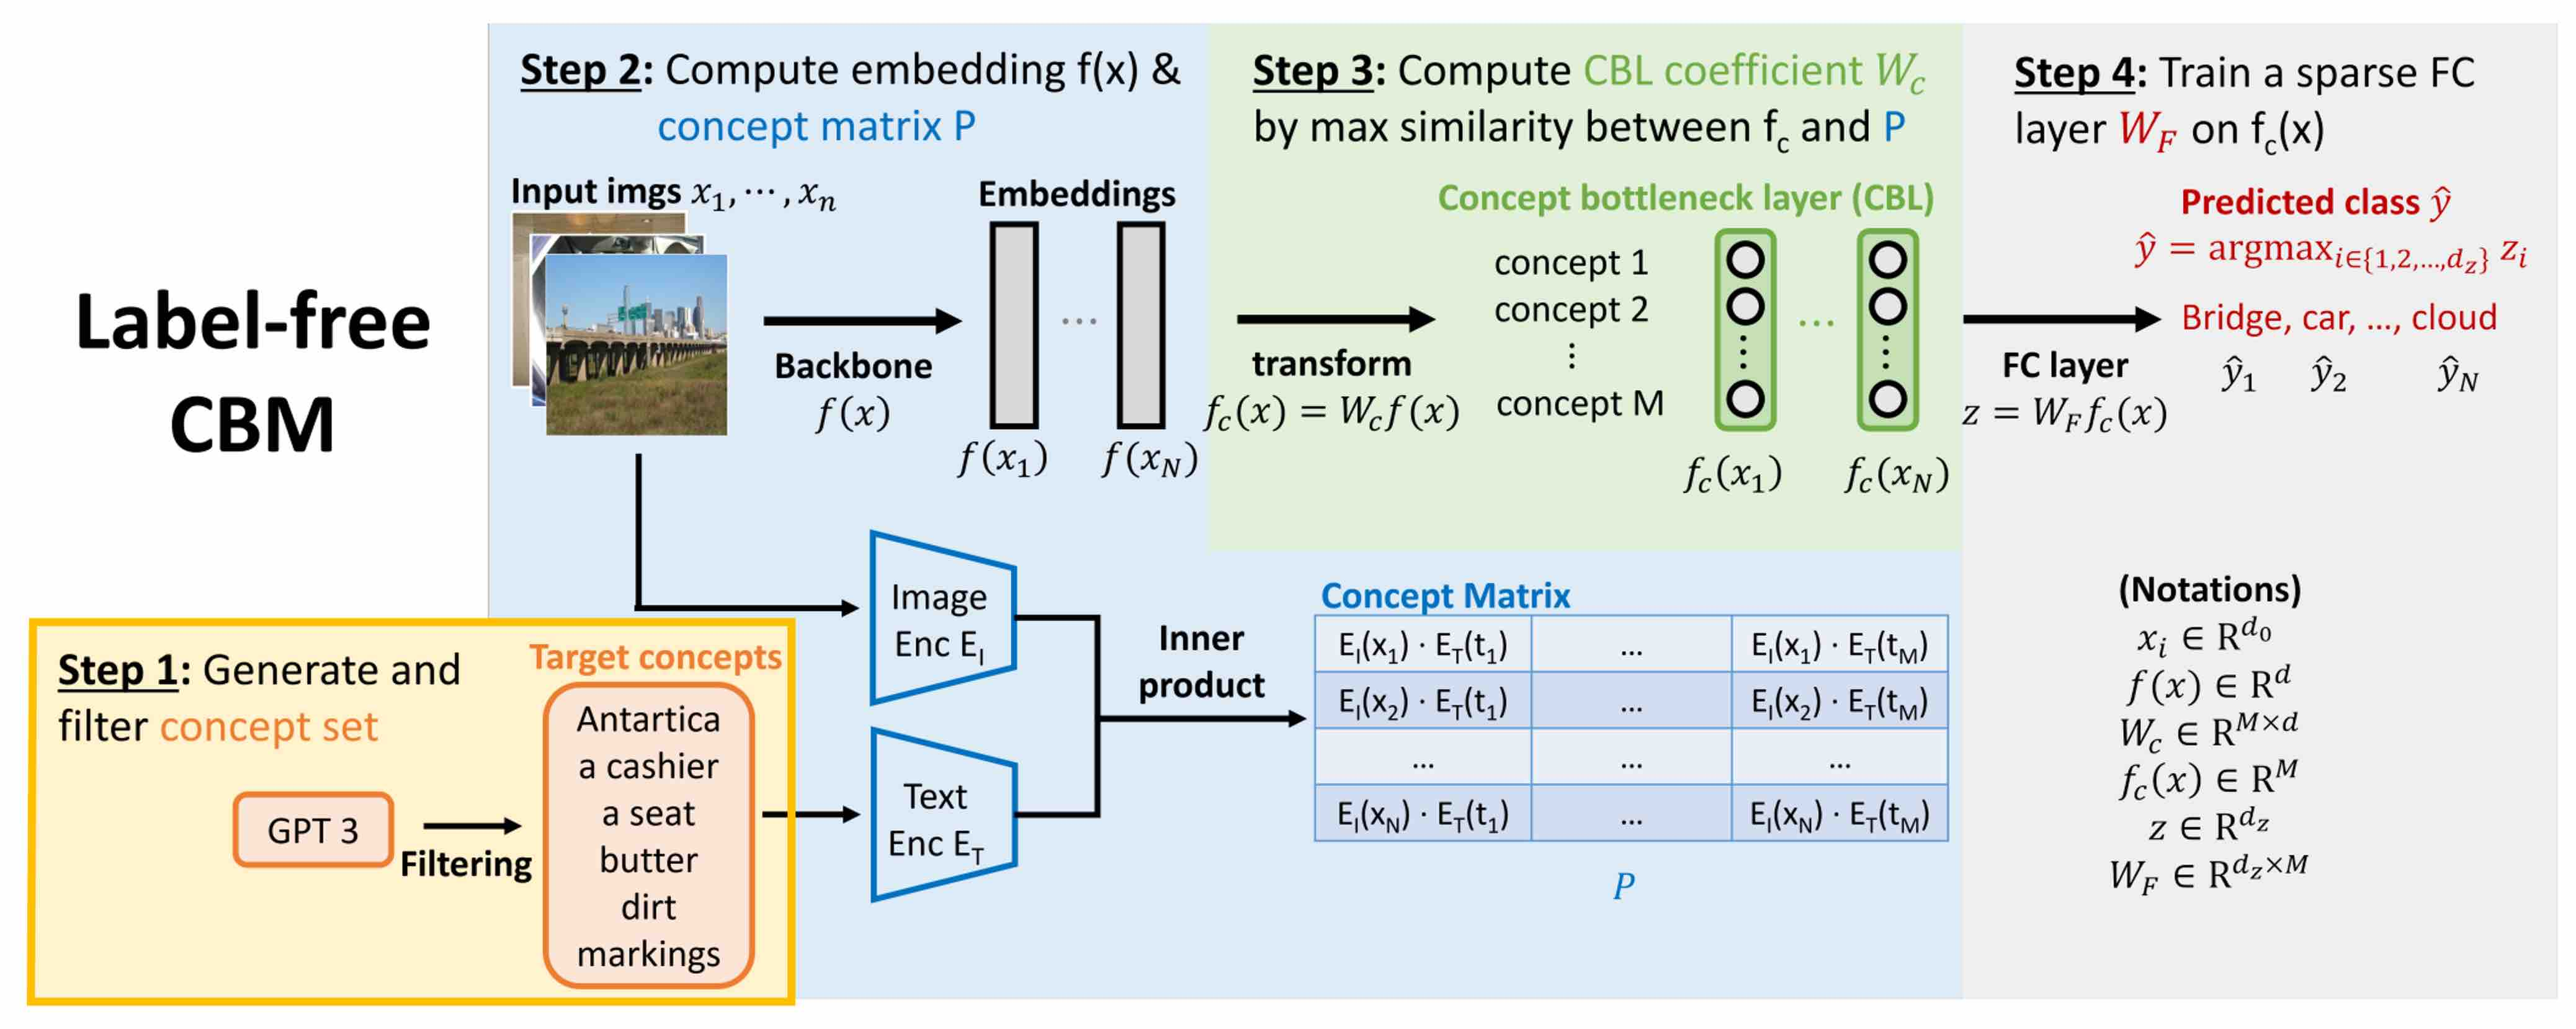

## 📦 Setup and Dependencies


👉 Run the cells below on Colab (GPU runtime) to clone the official repository and install all requirements. On a local machine, make sure you have CUDA‑enabled PyTorch ≥ 2.1.


In [ ]:
import os

is_colab = 'google.colab' in str(get_ipython())
current_dir = os.getcwd()


# Clone Label-free-CBM if needed
if not os.path.exists('Label-free-CBM'):
    !git clone https://github.com/Trustworthy-ML-Lab/Label-free-CBM.git

%cd Label-free-CBM

if is_colab:
    # Install required packages
    !pip install -r requirements.txt

# If you run the notebook locally, ensure to install the requirement


Cloning into 'Label-free-CBM'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 108 (delta 11), reused 10 (delta 10), pack-reused 72 (from 1)
Receiving objects: 100% (108/108), 6.51 MiB | 19.43 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/Label-free-CBM
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s et


## 🧠 Load Sentence Embedding Model

Load the `all-mpnet-base-v2` model from [SentenceTransformers](https://huggingface.co/sentence-transformers/all-mpnet-base-v2).


This model will be used to compute **semantic similarity between concepts and class labels**.

MPNet is chosen for its high-quality embeddings of short phrases and concepts.


In [ ]:
!bash download_models.sh

from sentence_transformers import SentenceTransformer

mpnet_model = SentenceTransformer('all-mpnet-base-v2')

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1fOUVzBpEt75s5IzY1HqcXiu6x9a830u7
From (redirected): https://drive.google.com/uc?id=1fOUVzBpEt75s5IzY1HqcXiu6x9a830u7&confirm=t&uuid=44721f05-7b91-4644-af6a-74d8320db0dc
To: /content/Label-free-CBM/saved_models.zip
100% 59.0M/59.0M [00:00<00:00, 59.8MB/s]
Archive:  saved_models.zip
   creating: saved_models/cifar10_lf_cbm/
  inflating: saved_models/cifar10_lf_cbm/args.txt  
  inflating: saved_models/cifar10_lf_cbm/b_g.pt  
  inflating: saved_models/cifar10_lf_cbm/concepts.txt  
  inflating: saved_models/cifar10_lf_cbm/metrics.txt  
  inflating: saved_models/cifar10_lf_cbm/proj_mean.pt  
  inflating: saved_models/cifar10_lf_cbm/proj_std.pt  
  inflating: saved_models/cifar10_lf_cbm/W_c.pt  
  inflating: saved_models/cifar10_lf_cbm/W_g.pt  
   creating: saved_models/cifar10_sparse_ft/
  inflating: saved_models/cifar10_sparse_ft/args.txt  
  inflating: saved_models/cifar10_sparse_ft/b_g.pt  
  inflating: saved_models/cifar

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## 🧾 Define Prompt Templates

Three types of prompts are defined to query the LLM:

- **important**: Key features that define the class.

    *List the most important features for recognizing something as a "goldfish": "bright orange color", "a small, round body", "a long, flowing tail",  "a small mouth", "orange fins" [...]  List the most important features for recognizing something as a \"{}\":*




- **superclass**: Broader categories the class belongs to.

    *Give superclasses for the word "tench": fish, vertebrate, animal. [..] Give superclasses for the word \"{}\":"*

- **around**: Objects or contexts commonly associated with the class.

    *List the things most commonly seen around a "tench": a pond, fish, a net, a rod, a reel, a hook, bait [...] List the things most commonly seen around a \"{}\":"*

These prompt types help capture diverse semantic aspects of each class.

In [ ]:
prompts = {
    "important": "List the most important features for recognizing something as a \"goldfish\":\n\n- bright orange color\n- a small, round body\n- a long, flowing tail\n- a small mouth\n- orange fins\n\nList the most important features for recognizing something as a \"beerglass\":\n\n- a tall, cylindrical shape\n- clear or translucent color\n- opening at the top\n- a sturdy base\n- a handle\n\nList the most important features for recognizing something as a \"{}\":",
    "superclass": "Give superclasses for the word \"tench\":\n\n- fish\n- vertebrate\n- animal\n\nGive superclasses for the word \"beer glass\":\n\n- glass\n- container\n- object\n\nGive superclasses for the word \"{}\":",
    "around": "List the things most commonly seen around a \"tench\":\n\n- a pond\n- fish\n- a net\n- a rod\n- a reel\n- a hook\n- bait\n\nList the things most commonly seen around a \"beer glass\":\n\n- beer\n- a bar\n- a coaster\n- a napkin\n- a straw\n- a lime\n- a person\n\nList the things most commonly seen around a \"{}\":"
}


## 📚 Load Class Labels

Load the list of class labels from the dataset (e.g., CIFAR-10). These labels serve as the input for concept generation.


In [ ]:
import data_utils  # Assuming this is a local utility module

dataset = "cifar10"

cls_file = data_utils.LABEL_FILES[dataset]
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']


## 🤖 Load LLM and Generate Concepts

Use Hugging Face’s `pipeline` to load the [Qwen3-1.7B](https://huggingface.co/Qwen/Qwen3-1.7B) model.

We will use this model to generate textual descriptions for each class.
We will then process these textual descriptions to derive the concepts.



In [ ]:
from transformers import pipeline

use_llm = True

# Load Mistral-7B-Instruct model from Hugging Face
generator = pipeline("text-generation",
                    model="Qwen/Qwen3-1.7B",
                    trust_remote_code=True)


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/622M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Device set to use cuda:0


## 🔍 Generate Concepts for Each Class

For each class label, we generate a list of concepts using the three prompt types.
We eclean the raw LLM output to extract bullet-pointed features.

We store the resulting concepts in a dictionary keyed by prompt type ant class label.


In [ ]:
import os
import json

verbose = False

concept_dict_by_prompt = {}

for prompt_type, base_prompt in prompts.items():

    feature_dict = {}

    for i, label in enumerate(classes):
        feature_dict[label] = set()
        # print("\n", i, label)

        prompt = base_prompt.format(label)
        response = \
        generator(prompt, max_new_tokens=50, do_sample=True, temperature=0.7)[
            0]['generated_text']

        # Clean up responses
        # print("\nInitial response", response)
        response = response[len(prompt):] # to remove initial prompt (only for gpt2)
        response = response[:response.find(f"{prompt.split(' ')[0]}")] # to remove further list
        features = response.split("\n-")
        features = [feat.replace("\n", "") for feat in features]
        features = [feat.strip() for feat in features]
        features = [feat for feat in features if len(feat) > 0]
        features = set(features)
        feature_dict[label].update(features)

        feature_dict[label] = sorted(list(feature_dict[label]))

        if verbose or i == 0:
            print("\nPrompt:", prompt)
            print("\nCleaned response:\n", "\n - ".join(feature_dict[label]))

    # Store the set of textual concept per type of prompt
    concept_dict_by_prompt[prompt_type] = feature_dict


Prompt: List the most important features for recognizing something as a "goldfish":

- bright orange color
- a small, round body
- a long, flowing tail
- a small mouth
- orange fins

List the most important features for recognizing something as a "beerglass":

- a tall, cylindrical shape
- clear or translucent color
- opening at the top
- a sturdy base
- a handle

List the most important features for recognizing something as a "airplane":

Cleaned response:
 a long, narrow body
 - a tail fin
 - four large, pointed wings
 - two large, flat wings
 - two large, pointed wings
 - two large, rounded wings


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Prompt: Give superclasses for the word "tench":

- fish
- vertebrate
- animal

Give superclasses for the word "beer glass":

- glass
- container
- object

Give superclasses for the word "airplane":

Cleaned response:
 machine
 - transport
 - vehicle

Prompt: List the things most commonly seen around a "tench":

- a pond
- fish
- a net
- a rod
- a reel
- a hook
- bait

List the things most commonly seen around a "beer glass":

- beer
- a bar
- a coaster
- a napkin
- a straw
- a lime
- a person

List the things most commonly seen around a "airplane":

Cleaned response:
 a flight attendant
 - a pilot
 - a plane
 - a runway
 - a seat
 - a wheel
 - an airport



## 💡 Why This Matters

Traditional CBMs require manual concept annotation, which is time-consuming and domain-specific. Label-Free CBMs use LLMs to automatically generate rich, interpretable concept sets. Prompt engineering allows us to extract meaningful and diverse concepts without human supervision.

---

# 🧹 Part 2: Concept Filtering and Pruning

After generating raw concepts from the LLM, we filter and refine them to ensure quality and interpretability. The goal is to remove noisy, overly long, or semantically redundant concepts before using them in the CBM pipeline.

We apply the following filters:


*   Length-Based Filtering. Concepts that exceed a maximum character length  are removed.

*   Text-Based Deduplication. Remove concepts that are exact matches or simple variations of class names.

* Semantic Similarity Filtering (Class-Level). Concepts that are too similar to any class label are removed.

* Semantic Similarity Filtering (Concept-Level). Concepts that are too similar to other concepts are pruned.



In [ ]:
import json
import data_utils
import conceptset_utils


"""
CLASS_SIM_CUTOFF: Concepts with cos similarity higher than this to any class will be removed
OTHER_SIM_CUTOFF: Concepts with cos similarity higher than this to another concept will be removed
MAX_LEN: max number of characters in a concept

PRINT_PROB: what percentage of filtered concepts will be printed
"""

OTHER_SIM_CUTOFF = 0.9

device = "cuda"


In [ ]:
if use_llm:
  important_dict, superclass_dict, around_dict = concept_dict_by_prompt['important'], concept_dict_by_prompt['superclass'], concept_dict_by_prompt['around']

else:
  # If we set use_llm to False, we load the concepts generated by gpt3 and provided by the authors of LF-CBM
  import json
  with open("data/concept_sets/gpt3_init/gpt3_{}_important.json".format(dataset), "r") as f:
      important_dict = json.load(f)
  with open("data/concept_sets/gpt3_init/gpt3_{}_superclass.json".format(dataset), "r") as f:
      superclass_dict = json.load(f)
  with open("data/concept_sets/gpt3_init/gpt3_{}_around.json".format(dataset), "r") as f:
      around_dict = json.load(f)

  with open(data_utils.LABEL_FILES[dataset], "r") as f:
      classes = f.read().split("\n")

concepts = set()

for values in important_dict.values():
    concepts.update(set(values))

for values in superclass_dict.values():
    concepts.update(set(values))

for values in around_dict.values():
    concepts.update(set(values))

print(len(concepts))

119


## ✂️ Length-Based Filtering

Concepts that exceed a maximum character length (`MAX_LEN`) are removed.

- Long phrases tend to be less interpretable or overly specific.
- This step ensures that retained concepts are concise and human-readable.


In [ ]:
import random

MAX_LEN = 30
PRINT_PROB = 1


new_concepts = []
for concept in concepts:
    if len(concept) <= MAX_LEN:
        new_concepts.append(concept)
    else:
        if random.random()<PRINT_PROB:
            print(len(concept), concept)
print(len(concepts), len(new_concepts))
concepts = new_concepts


79 a long, narrow tailNow, I need to create a function that can distinguish betwee
119 118



## 🧼 Text-Based Deduplication

Remove concepts that are exact matches or simple variations of class names.

- This avoids circular reasoning (e.g., using "dog" to explain "dog").
- Variants like "a dog", "the dog", or "Dog" are stripped out.


In [ ]:
import random
from conceptset_utils import _clip_dot_prods

PRINT_PROB = 1


#first check simple text matches
print(len(concepts))
concepts = list(concepts)
concepts = sorted(concepts)

for cls in classes:
    for prefix in ["", "a ", "A ", "an ", "An ", "the ", "The "]:
        try:
            concepts.remove(prefix+cls)
            if random.random()<PRINT_PROB:
                print("Class:{} - Deleting {}".format(cls, prefix+cls))
        except(ValueError):
            pass
    try:
        concepts.remove(cls.upper())
    except(ValueError):
        pass
    try:
        concepts.remove(cls[0].upper()+cls[1:])
    except(ValueError):
        pass
print(len(concepts))


118
Class:cat - Deleting a cat
Class:ship - Deleting a ship
Class:truck - Deleting a truck
115



## 🔍 Semantic Similarity Filtering (Class-Level)

Use MPNet embeddings to compute cosine similarity between each concept and each class label.

- Concepts that are **too similar** to any class label (above `CLASS_SIM_CUTOFF`) are removed.
- This prevents concepts from being trivial restatements of the class itself.


- Similarity is computed using a weighted combination of:
  - MPNet embeddings
  - CLIP-based dot products (via `_clip_dot_prods`)


In [ ]:
CLASS_SIM_CUTOFF = 0.85

class_features_m = mpnet_model.encode(classes)
concept_features_m = mpnet_model.encode(concepts)
dot_prods_m = class_features_m @ concept_features_m.T
dot_prods_c = _clip_dot_prods(classes, concepts)
dot_prods = (dot_prods_m + 3*dot_prods_c)/4

to_delete = []
for i in range(len(classes)):
    for j in range(len(concepts)):
        prod = dot_prods[i,j]
        if prod >= CLASS_SIM_CUTOFF and i!=j:
            if j not in to_delete:
                to_delete.append(j)
                if random.random()<PRINT_PROB:
                    print("Class:{} - Concept:{}, sim:{:.3f} - Deleting {}".format(classes[i], concepts[j], dot_prods[i,j], concepts[j]))
                    print("".format(concepts[j]))

to_delete = sorted(to_delete)[::-1]

for item in to_delete:
    concepts.pop(item)
print(len(concepts))

100%|███████████████████████████████████████| 335M/335M [00:18<00:00, 18.7MiB/s]


Class:airplane - Concept:a plane, sim:0.876 - Deleting a plane

Class:automobile - Concept:a car, sim:0.881 - Deleting a car

Class:automobile - Concept:vehicle, sim:0.904 - Deleting vehicle

Class:dog - Concept:animal, sim:0.855 - Deleting animal

111


## 🔁 Semantic Similarity Filtering (Concept-Level)

Use MPNet and CLIP embeddings to compare concepts with each other.

- Concepts that are **too similar to other concepts** (above `OTHER_SIM_CUTOFF`) are pruned.
- This reduces redundancy and encourages diversity in the concept set.


- When two concepts are too similar:
  - The one with **lower average similarity** to other concepts is deleted.
  - This favors more general and reusable concepts.


In [ ]:
import numpy as np
concept_features = mpnet_model.encode(concepts)

dot_prods_m = concept_features @ concept_features.T
dot_prods_c = _clip_dot_prods(concepts, concepts)

dot_prods = (dot_prods_m + 3*dot_prods_c)/4

to_delete = []
for i in range(len(concepts)):
    for j in range(len(concepts)):
        prod = dot_prods[i,j]
        if prod >= OTHER_SIM_CUTOFF and i!=j:
            if i not in to_delete and j not in to_delete:
                to_print = random.random() < PRINT_PROB
                #Deletes the concept with lower average similarity to other concepts - idea is to keep more general concepts
                if np.sum(dot_prods[i]) < np.sum(dot_prods[j]):
                    to_delete.append(i)
                    if to_print:
                        print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[i]))
                else:
                    to_delete.append(j)
                    if to_print:
                        print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[j]))

to_delete = sorted(to_delete)[::-1]
for item in to_delete:
    concepts.pop(item)
print(len(concepts))


a front and a rear bumper - a front bumper , sim:0.9086 - Deleting a front and a rear bumper
a long neck - a long, slender neck , sim:0.9293 - Deleting a long neck
a long, slender tail - a long, slim tail , sim:0.9661 - Deleting a long, slim tail
a wheel - a wheelTh , sim:0.9145 - Deleting a wheel
four large, pointed wings - two large, pointed wings , sim:0.9317 - Deleting two large, pointed wings
four legs - two legs , sim:0.9147 - Deleting four legs
large paws - paws , sim:0.9050 - Deleting large paws
transport - transportation , sim:0.9618 - Deleting transport
two large, flat wings - two large, rounded wings , sim:0.9421 - Deleting two large, flat wings
102





## 📌 Summary of Filtering

After all filtering steps:

- The concept set is significantly reduced.
- Remaining concepts are:
  - Short and interpretable
  - Distinct from class labels
  - Semantically diverse

This refined concept set will be used to annotate images and train the CBM.

---

| Filter Type              | Purpose                                                  |
|--------------------------|----------------------------------------------------------|
| Length Filter            | Remove overly long or verbose concepts                   |
| Text Deduplication       | Eliminate class name variants                            |
| Class Similarity Filter  | Remove concepts too close to class labels                |
| Concept Similarity Filter| Remove redundant concepts with high mutual similarity    |



---



We will later apply two additional filters:
- Remove concepts that don’t activate CLIP highly.
- Remove concepts we can’t project accurately, remove the ones that are not interpretable from the CBL.
---

# 🧬 Part 3: Feature Extraction and Annotation

We extract image and concept features using CLIP and compute their associations. These associations form the basis for training the Concept Bottleneck Model (CBM) without manual annotations.

---



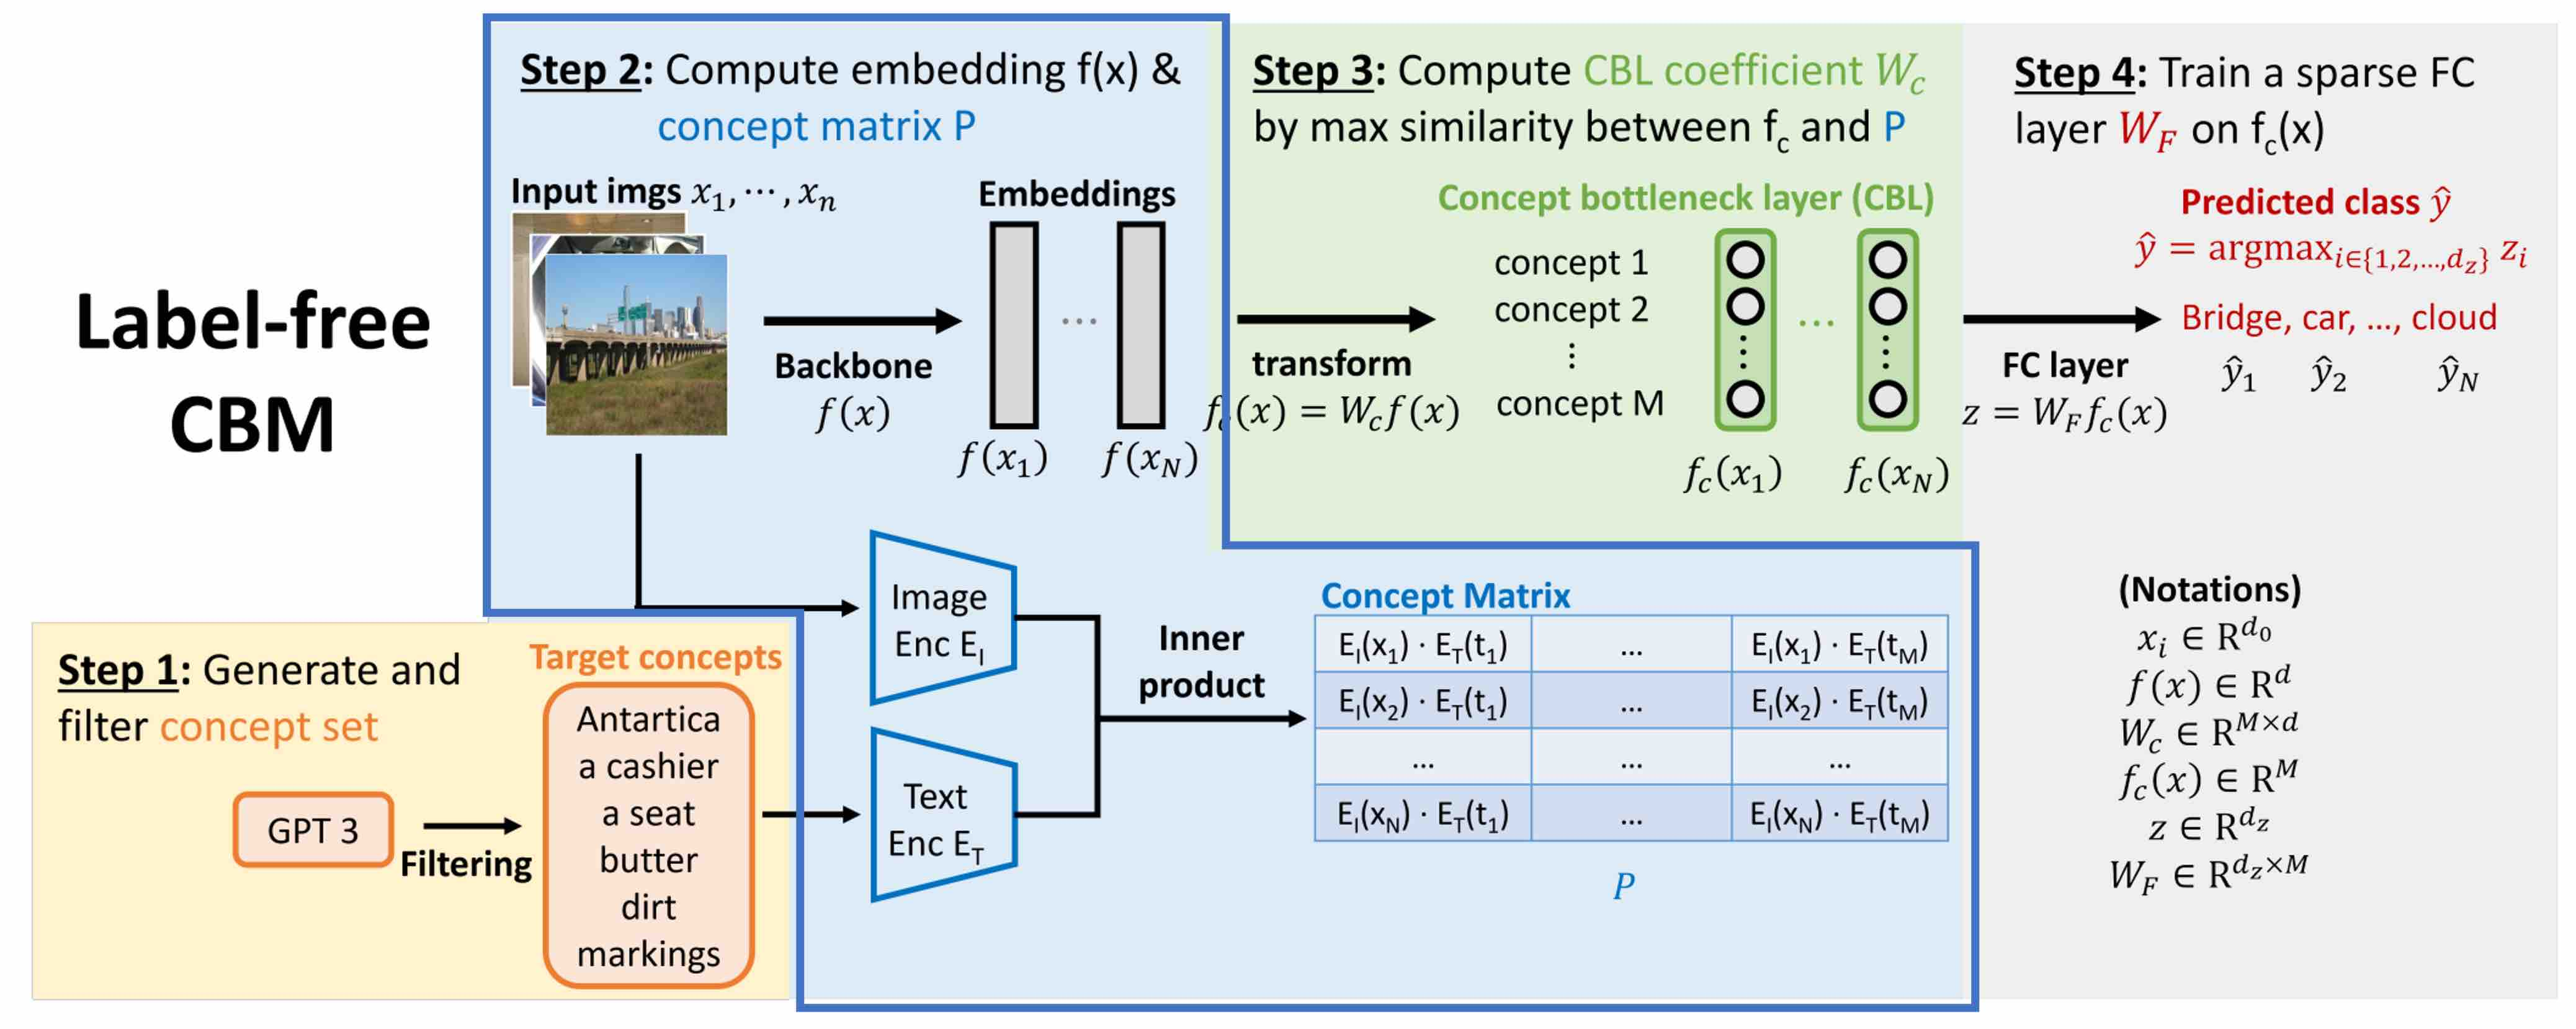

### 🗂️ Setup and Activation Data Preparation

This block initializes default hyperparameters and prepares the environment by downloading precomputed CLIP activations encoded by the image encoder from Google Drive. These activations allows for computing image–concept associations without preprocessing raw images. The ZIP file is automatically extracted into the working directory for later use.


In [ ]:
import gdown
import zipfile
import os
import argparse

# Default arguments
default_args = {
    "dataset": "cifar10",
    "backbone": "clip_RN50",
    "clip_name": "ViT-B/16",
    "device": "cuda",
    "proj_steps": 1000,
    "proj_batch_size": 50000,
    "clip_cutoff": 0.25,
    "interpretability_cutoff": 0.45,
    "lam": 0.0007,
    "n_iters": 1000,
    "saga_batch_size": 256,
    "pool_mode": "avg"
}

args = argparse.Namespace(**default_args)
os.makedirs("activations", exist_ok=True)

files = {
    "activations.zip": "1DmYz5AA9oCEZ0qmBdSR__xRMZl1Y-5XU"
}
for filename, file_id in files.items():
    gdown.download(id=file_id, output=filename)

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("")
    print(f"Extracted {filename}")


Downloading...
From (original): https://drive.google.com/uc?id=1DmYz5AA9oCEZ0qmBdSR__xRMZl1Y-5XU
From (redirected): https://drive.google.com/uc?id=1DmYz5AA9oCEZ0qmBdSR__xRMZl1Y-5XU&confirm=t&uuid=600d3354-9dde-4638-9970-14a8f1f5d413
To: /content/Label-free-CBM/activations.zip
100%|██████████| 263M/263M [00:05<00:00, 48.7MB/s]


Extracted activations.zip


## 🖼️ Image Feature Extraction with CLIP

Use CLIP to extract image embeddings for both training and validation splits.

- CLIP encodes images into a high-dimensional semantic space.
- These embeddings capture rich visual features aligned with natural language.

```python
clip_model, clip_preprocess = clip.load(args.clip_name, device=args.device)
```

- Features are cached to avoid recomputation.
- Batches of images are processed using a DataLoader for efficiency.



In [ ]:
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import clip
from utils import get_activation
import data_utils


os.makedirs("activations", exist_ok=True)
clip_name_clean = args.clip_name.replace("/", "")

# Paths
path_clip_train = f"activations/clip_image_emb_{args.dataset}_{clip_name_clean}_train.pt"
path_clip_val = f"activations/clip_image_emb_{args.dataset}_{clip_name_clean}_val.pt"
path_concept_emb = f"activations/clip_concept_emb_{args.dataset}_{clip_name_clean}.pt"
path_concept_list = f"data/concept_sets/{args.dataset}_filtered.txt"

def get_image_features(path, split):
    if os.path.exists(path):
        print(f"[Cache] Loaded {split} features from: {path}")
        return torch.load(path, map_location=args.device)

    features = []
    clip_model, clip_preprocess = clip.load(args.clip_name, device=args.device)
    d_probe = f"{args.dataset}_{split}"
    data_c = data_utils.get_data(d_probe, clip_preprocess)
    with torch.no_grad():
        for images, _ in tqdm(DataLoader(data_c, batch_size=100, num_workers=2, pin_memory=True),
                                desc=f"Extracting CLIP {split} image features"):
            features.append(clip_model.encode_image(images.to(args.device)).cpu())
    features = torch.cat(features)
    torch.save(features, path)
    return features

train_clip = get_image_features(path_clip_train, "train")
val_clip = get_image_features(path_clip_val, "val")


[Cache] Loaded train features from: activations/clip_image_emb_cifar10_ViT-B16_train.pt
[Cache] Loaded val features from: activations/clip_image_emb_cifar10_ViT-B16_val.pt


## 🧠 Concept Embedding with CLIP

Use CLIP’s text encoder to embed the filtered concept list.

Loads cached concept embeddings from `path_concept_emb` if available and we want top use gpt-3 stored concept.

Otherwise,  
- We tokenizes the concept list using `clip.tokenize(...)`.
- Loads the CLIP model via `clip.load(...)` to access the text encoder.
- Encodes concepts `clip_model.encode_text(...)` in batches to avoid memory issues and concatenates the results.

These embeddings represent each concept in the same semantic space as the image features, enabling direct comparison.


In [ ]:
if os.path.exists(path_concept_emb) and use_llm is False:
    print(f"[Cache] Loaded text features from: {path_concept_emb}")
    concept_emb = torch.load(path_concept_emb, map_location=args.device)
else:
    # We encode the concepts using CLIP text encoder
    tokens = clip.tokenize(concepts).to(args.device)
    concept_emb = []
    clip_model, _ = clip.load(args.clip_name, device=args.device)
    with torch.no_grad():
        for i in tqdm(range(0, len(tokens), 100), desc="Extracting concept embeddings"):
            concept_emb.append(clip_model.encode_text(tokens[i:i+100]))
    concept_emb = torch.cat(concept_emb, dim=0)
    torch.save(concept_emb, path_concept_emb)
    print(f"CLIP concept embeddings computed")


Extracting concept embeddings: 100%|██████████| 2/2 [00:00<00:00, 21.73it/s]

CLIP concept embeddings computed


## 🔗 Image–Concept Association and Filtering

This block computes similarity scores between image embeddings and concept embeddings, then **filters out weakly aligned concepts**.

- Normalizes both image and concept embeddings to unit vectors for cosine similarity.
- Computes similarity scores via dot product (`@`) between images and concepts.
- For each concept, calculates the average similarity of its top 5 associated training images.
- Applies a cutoff (`args.clip_cutoff`) to **retain only concepts with strong visual alignment** — i.e., those that appear on average within the top-5 above the threshold.

This ensures that the final concept set is not only interpretable but also visually grounded in the dataset.


In [ ]:
# train_clip and val_clip are the CLIP image embeddings of the train and validation set
train_clip = train_clip / train_clip.norm(dim=1, keepdim=True)
val_clip = val_clip / val_clip.norm(dim=1, keepdim=True)
# concept_emb are the CLIP concept (text) embedding
concept_emb = concept_emb / concept_emb.norm(dim=1, keepdim=True)

# Similitarity via dot product
train_scores = train_clip @ concept_emb.T
val_scores = val_clip @ concept_emb.T

# Average similarity score of the top 5 associated training images
top5 = torch.topk(train_scores, k=5, dim=0)[0].mean(dim=0)
# Retain only the concepts with strong visual alignment
mask = top5 > args.clip_cutoff

concepts = [c for i, c in enumerate(concepts) if mask[i]]

train_scores = train_scores[:, mask]
val_scores = val_scores[:, mask]

print(f"[Filter] Retained {len(concepts)} concepts after cutoff")


[Filter] Retained 98 concepts after cutoff


## ⚡ Extracting and Caching Model Activations

Extracts **visual activations from the backbone model** for train and val splits. In the tutorial, we use pre-computed visual activations.

- Loads cached activations if available; otherwise computes them via a forward hook on `layer4`.
- Supports CLIP and custom models with optional pooling (`avg` by default).
- Saves activations to disk for reuse.

Returns `(train_activations, val_activations)` for downstream tasks.


In [ ]:

activation_splits = []
for split in ['train', 'val']:
    path = os.path.join("activations", f"activation_{args.dataset}_{args.backbone}_{split}.pt")
    if os.path.exists(path):
        # We load the cached visual activation from the backbone model
        print(f"[Cache] Loaded model activations from: {path}")
        activation_splits.append(torch.load(path, map_location=args.device))
        continue

    if args.backbone.startswith("clip_"):
        target_model, target_preprocess = clip.load(args.backbone[5:], device=args.device)
    else:
        target_model, target_preprocess = data_utils.get_target_model(args.backbone, args.device)

    d_probe = f"{args.dataset}_{split}"
    data_t = data_utils.get_data(d_probe, target_preprocess)

    pool_mode = getattr(args, "pool_mode", "avg")
    activations = []
    hook = target_model.visual.layer4.register_forward_hook(get_activation(activations, pool_mode))

    with torch.no_grad():
        for images, _ in tqdm(DataLoader(data_t, batch_size=100, num_workers=2, pin_memory=True),
                                desc=f"Extracting {args.backbone} {split} activations"):
            _ = target_model.encode_image(images.to(args.device))
    hook.remove()
    activations = torch.cat(activations)
    activation_splits.append(activations)
    torch.save(activations, path)

train_activations, val_activations = activation_splits[0], activation_splits[1]


[Cache] Loaded model activations from: activations/activation_cifar10_clip_RN50_train.pt
[Cache] Loaded model activations from: activations/activation_cifar10_clip_RN50_val.pt


## 📌 Part 3 Summary: Concept Embedding and Activation Alignment

In this part, we:
1. **Encoded textual concepts** into CLIP embeddings to represent semantic meaning.
2. **Computed image-concept similarity scores** using normalized CLIP embeddings.
3. **Applied a top-5 mean similarity cutoff** to retain only strongly aligned concepts.
4. **Extracted and cached model activations** from the visual backbone for both train and val splits.

This yields a filtered set of interpretable concepts and corresponding visual features, ready for concept-based classification in the next stage.
___

# 🧠 Part 4: Concept Projection and Final Classification





## 🔄 1. Activation Preparation
- Converts all activation and score tensors to `float32` and moves them to the target device.
- Ensures compatibility for training the projection and classifier layers.

In [ ]:
from similarity import cos_similarity_cubed_single
from torch.utils.data import DataLoader, TensorDataset

train_activations = train_activations.to(torch.float32).to(args.device)
val_activations = val_activations.to(torch.float32).to(args.device)
train_scores = train_scores.to(torch.float32).to(args.device)
val_scores = val_scores.to(torch.float32).to(args.device)

n_concepts = train_scores.shape[1]


## 📐 2. Training the Concept Projection Layer

- Initializes a linear layer to map visual activations to concept scores.
- Trains using a custom cosine-cubed similarity loss to align projected activations with CLIP-derived concept scores.
- Uses early stopping based on validation loss to select the best weights.


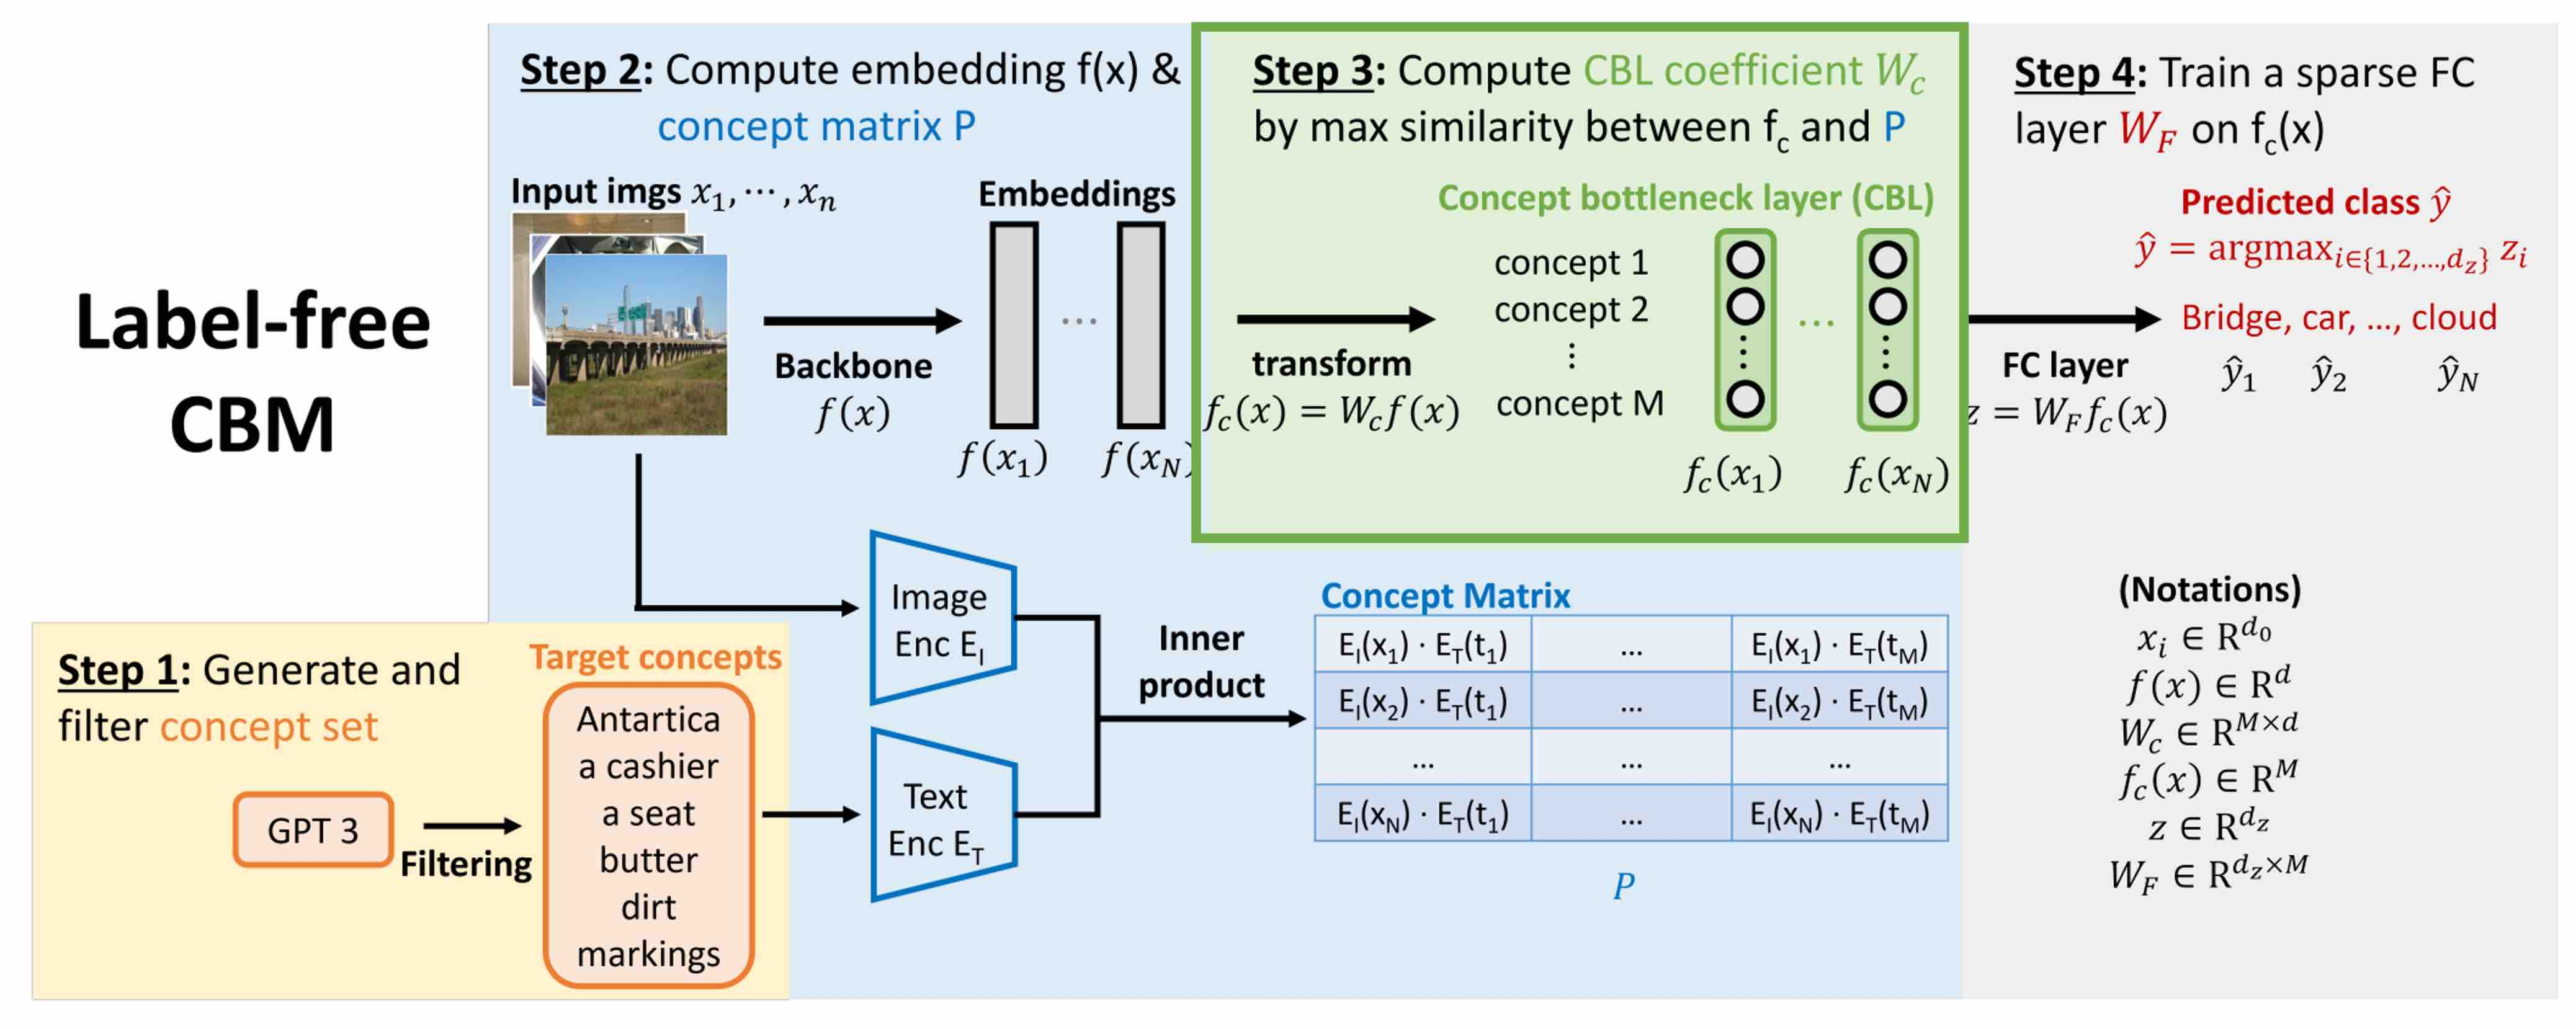

In [ ]:
# Train projection layer
proj = torch.nn.Linear(train_activations.shape[1], len(concepts), bias=False).to(args.device)
opt = torch.optim.Adam(proj.parameters(), lr=1e-3)
best_loss, best_weights = float("inf"), None
for step in range(args.proj_steps):
    batch = random.sample(range(len(train_activations)),
                          k=min(args.proj_batch_size, len(train_activations)))
    out = proj(train_activations[batch])
    # Trains using a custom cosine-cubed similarity loss to align
    # - projected activations (out)
    # - with CLIP-derived concept scores (train_scores,
    # derived as the cosine similarity between CLIP image embeddings and CLIP embedding of textual concepts).
    loss = -cos_similarity_cubed_single(train_scores[batch], out).mean()
    loss.backward(); opt.step(); opt.zero_grad()
    with torch.no_grad():
        val_out = proj(val_activations)
        val_loss = -cos_similarity_cubed_single(val_scores, val_out).mean()
        if val_loss < best_loss:
            best_loss, best_weights = val_loss, proj.weight.clone()
        else:
            break
proj.load_state_dict({"weight": best_weights})

<All keys matched successfully>


## 🧹 3. Filtering Uninterpretable Concepts
- Applies the trained projection to validation activations.
- Filters out concepts with low similarity to CLIP scores using an `interpretability_cutoff`.
- Retains only interpretable concepts and updates the projection weights accordingly.


In [ ]:
with torch.no_grad():
    val_out = proj(val_acti vations)
    sim = cos_similarity_cubed_single(val_scores, val_out)
    mask = sim > args.interpretability_cutoff
    concepts = [c for i, c in enumerate(concepts) if mask[i]]
    W_c = proj.weight[mask]
    print(f"{mask.sum()} concepts retained after training")

95 concepts retained after training



## 🧪 4. Final Concept-Based Classifier
- Reinitializes the projection layer with filtered concept weights.
- Applies it to train and val activations to get concept-level features.
- Normalizes features using training set statistics (mean and std).
- Loads ground-truth labels and wraps data into loaders.


In [ ]:
from glm_saga.elasticnet import IndexedTensorDataset, glm_saga

# Final classifier
proj = torch.nn.Linear(train_activations.shape[1], len(concepts), bias=False).to(args.device)
proj.load_state_dict({"weight": W_c})
train_c = proj(train_activations)
val_c = proj(val_activations)
mean, std = train_c.mean(0), train_c.std(0)
train_c = (train_c - mean) / std
val_c = (val_c - mean) / std


## 🧮 5. Sparse Linear Classification (GLM-SAGA)
- Trains a sparse linear classifier using the GLM-SAGA optimizer.
- Applies elastic net regularization to encourage interpretability and sparsity.
- Extracts final classifier weights `W_F` and bias `b_F` for downstream evaluation.


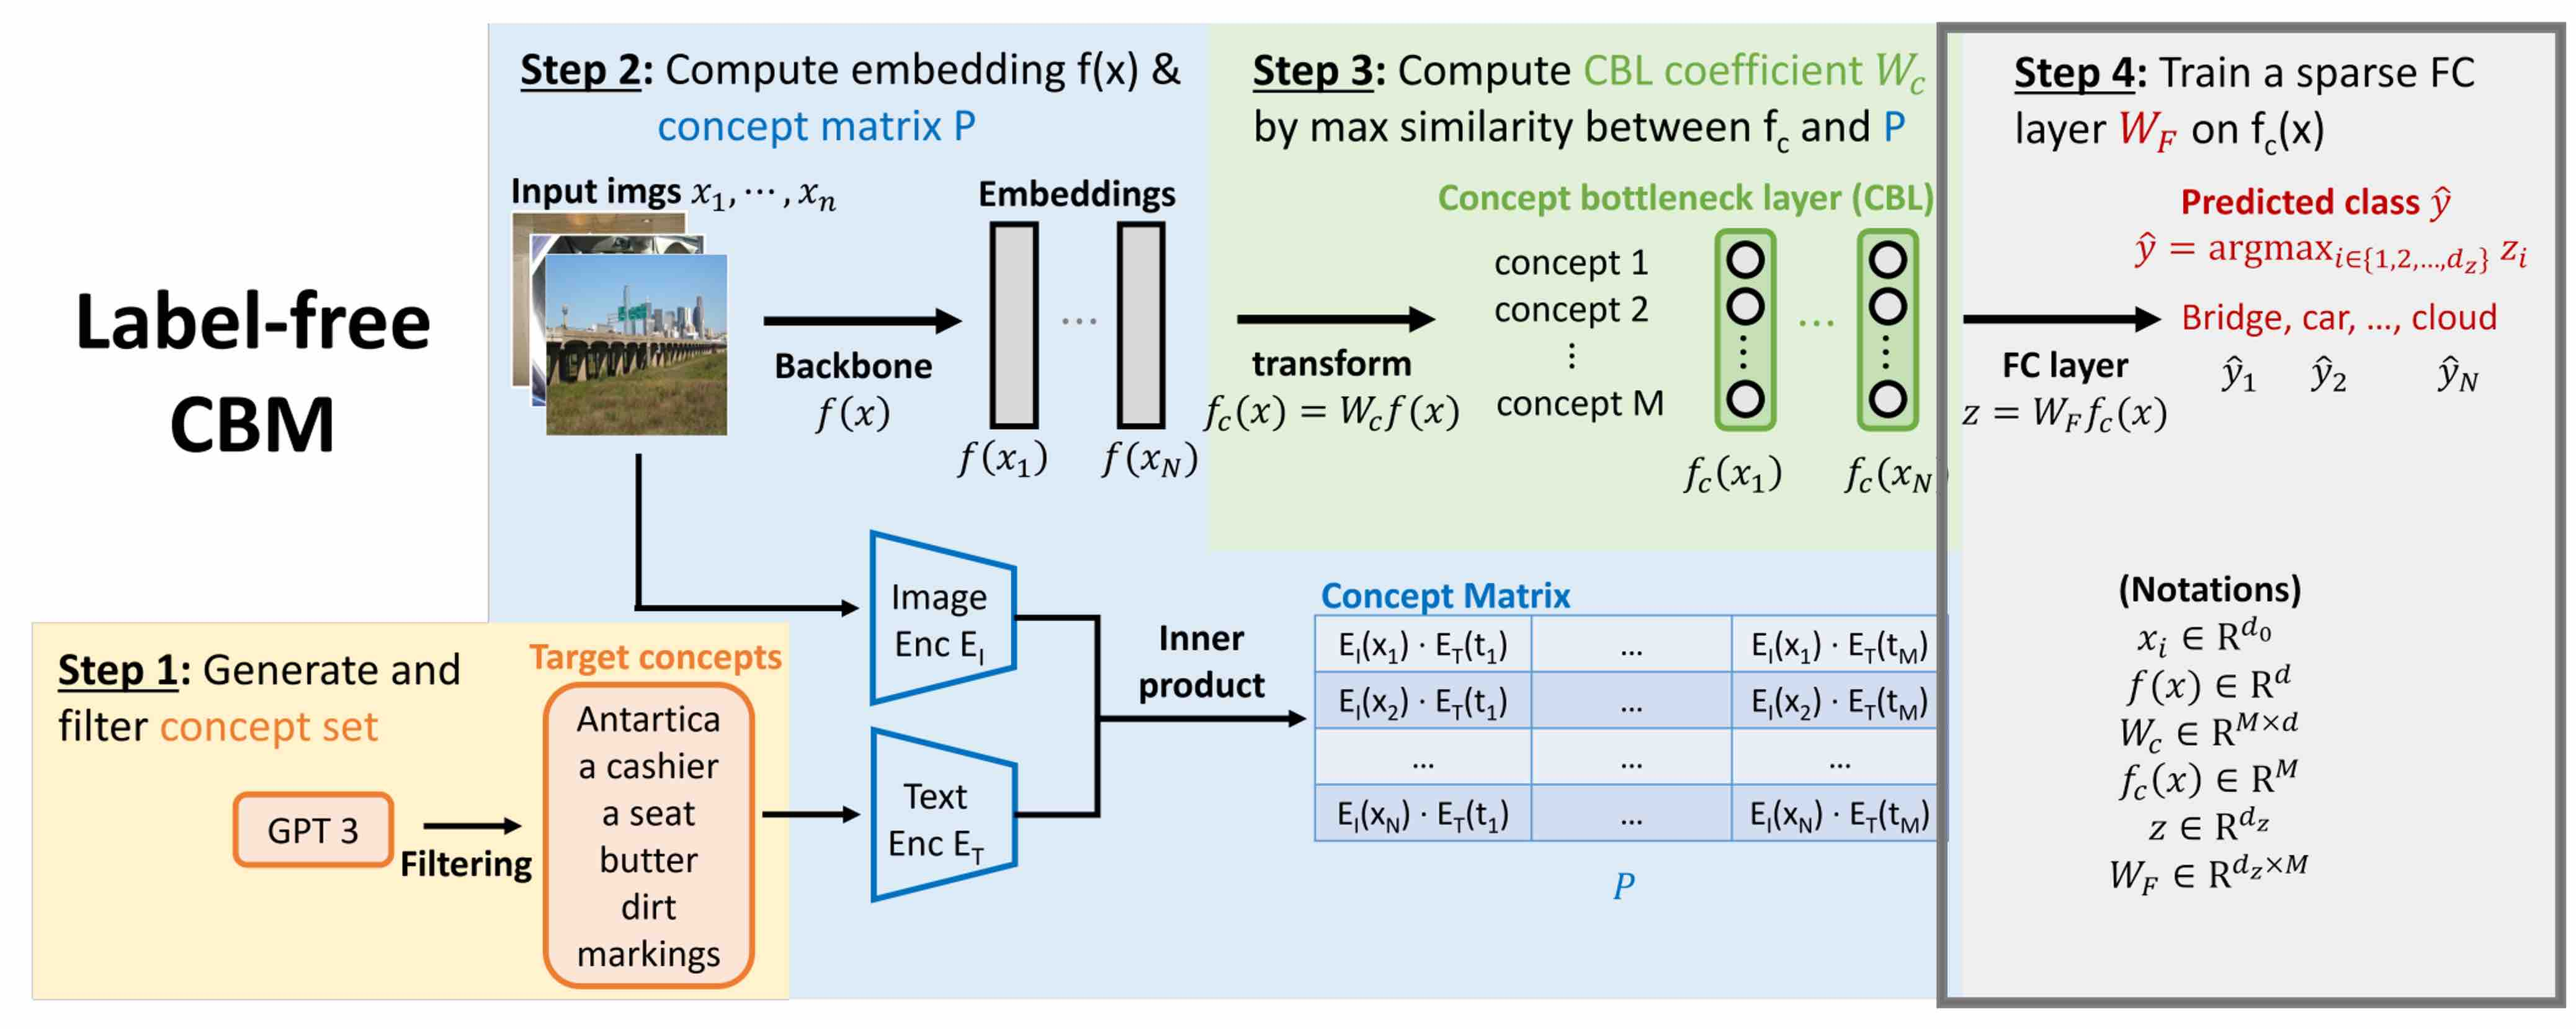

In [ ]:
train_y = torch.LongTensor(data_utils.get_targets_only(args.dataset + "_train"))
val_y = torch.LongTensor(data_utils.get_targets_only(args.dataset + "_val"))
train_ds = IndexedTensorDataset(train_c, train_y)
val_ds = TensorDataset(val_c, val_y)
train_loader = DataLoader(train_ds, batch_size=args.saga_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=args.saga_batch_size)

linear = torch.nn.Linear(train_c.shape[1], len(classes)).to(args.device)
linear.weight.data.zero_(); linear.bias.data.zero_()
output = glm_saga(linear, train_loader, 0.1, args.n_iters, 0.99, epsilon=1, k=10,
                    val_loader=val_loader, metadata={'max_reg': {'nongrouped': args.lam}},
                    n_ex=len(train_c), n_classes=len(classes))

W_F = output['path'][0]['weight']
b_F = output['path'][0]['bias']

  7%|▋         | 71/1000 [01:03<13:52,  1.12it/s]


(0) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8607] [test acc -1.0000], sparsity 0.36526315789473685 [347/950], time 64.18710494041443, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(1) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.36526315789473685 [347/950], time 0.8462445735931396, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(2) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.6465620994567871, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(3) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.599621057510376, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(4) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.7111096382141113, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(5) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 1.345848798751831, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(6) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.6101949214935303, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(7) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.5929501056671143, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(8) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.8821370601654053, lr 0.1000


  0%|          | 0/1000 [00:00<?, ?it/s]


(9) lambda 0.0007, loss 0.4227, acc 0.8708 [val acc 0.8606] [test acc -1.0000], sparsity 0.3642105263157895 [346/950], time 0.8359808921813965, lr 0.1000


 12%|█▏        | 117/1000 [01:18<09:53,  1.49it/s]


(10) lambda 0.0000, loss 0.3405, acc 0.8810 [val acc 0.8662] [test acc -1.0000], sparsity 1.0 [950/950], time 79.26962852478027, lr 0.1000




## 📊 6. Evaluation on Validation Set
- Applies the trained linear classifier to validation features.
- Computes logits and predicted classes.
- Aggregates predictions across batches and compares with ground-truth labels.
- Reports final validation accuracy as a performance metric.


In [ ]:
import torch
import torch.nn.functional as F

# Move weights and bias to the correct device
W_F = W_F.to(args.device)
b_F = b_F.to(args.device)

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(args.device)
        val_y = val_y.to(args.device)

        # Linear model: logits = x @ W.T + b
        logits = val_x @ W_F.T + b_F

        # Predicted class
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds)
        all_labels.append(val_y)

# Concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute accuracy
accuracy = (all_preds == all_labels).float().mean().item()
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8607


# 🔍 Part 5: Concept Importance Visualization  

We explore LF-CBM interpretability from two angles:

- Model-Level (Globally for classes): A Sankey diagram shows how concepts influence each class across the entire model.

- Example-Level (Local): For a specific prediction, we highlight which concepts supported or opposed the decision.

Together, these views reveal both the global logic and local reasoning behind LF-CBM predictions

## 🌐 Model level explanation: Sankey Diagram of class-concept importances

You can build a Sankey diagram of weights, showing the importance of each concept for a number of selected classes

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import to_rgba
import plotly.graph_objects as go

to_show = random.choices([i for i in range(len(classes))], k=1)
labels = list(concepts) + [classes[i] for i in to_show]
source = []
target = []
value = []
color = []

# Get the colormap function
cmap = cm.get_cmap("tab20")

# Generate one color per concept
concept_colors = [to_rgba(cmap(i / len(concepts)), alpha=0.6) for i in range(len(concepts))]

# Convert to Plotly-compatible RGBA strings
concept_color_map = {
    concept: f"rgba({int(r*255)},{int(g*255)},{int(b*255)},{a})"
    for concept, (r, g, b, a) in zip(concepts, concept_colors)
}
for i in to_show:
    class_label = classes[i]
    target_idx = len(concepts) + to_show.index(i)
    for j in range(len(concepts)):
        weight = W_F[i, j].item()
        if abs(weight) > 0.05:
            source.append(j)
            target.append(target_idx)
            value.append(abs(weight))
            color.append("rgba(0,128,0,0.4)" if weight > 0 else "rgba(255,0,0,0.4)")

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    ))])

fig.update_layout(title_text="Concept–Class Importance Sankey Diagram", font_size=10)
fig.show()

/tmp/ipython-input-3194986631.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")


## 📍 Local, example level expanation: influential concept ranks
Let's now focus on explantions for individual predictions.

Let's first re-construct the CBM model

In [ ]:
from cbm import CBM_model
model = CBM_model(args.backbone, W_c, W_F, b_F, mean, std, device)

100%|███████████████████████████████████████| 244M/244M [00:29<00:00, 8.59MiB/s]


🔍 Let's now visualize some model predictions and explain them using concept contributions.

For each randomly selected image, we show:

- The top predicted class
- A bar plot of the most influential concepts

In this way we can highlight how the model arrives at its decision!


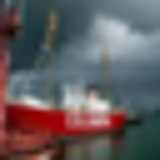

Image:7706 Gt:ship, 1st Pred:ship, 9.376, 2nd Pred:airplane, 3.584


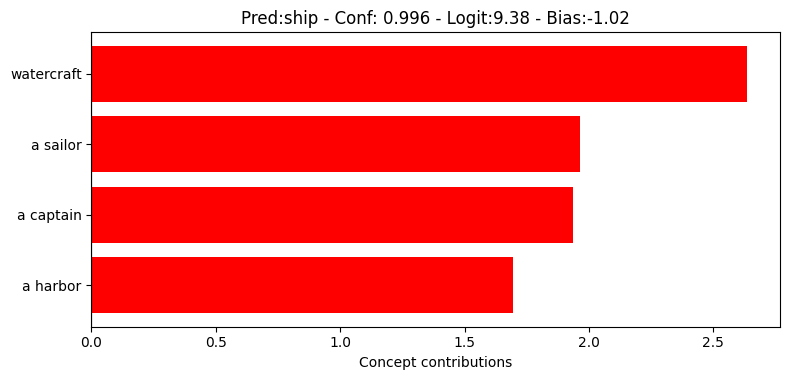

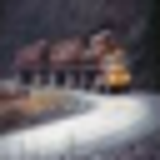

Image:2495 Gt:truck, 1st Pred:ship, 3.775, 2nd Pred:deer, 1.199


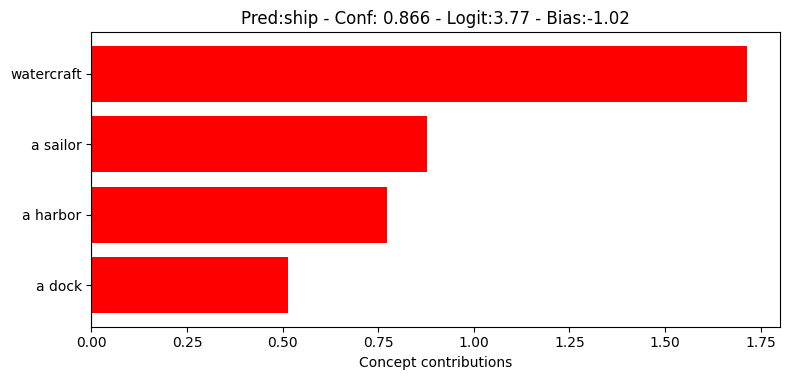

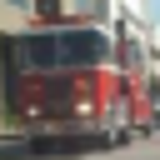

Image:816 Gt:truck, 1st Pred:truck, 9.114, 2nd Pred:automobile, 3.997


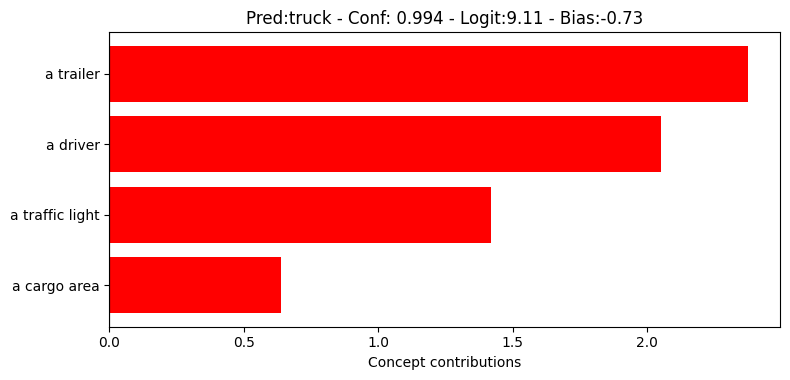

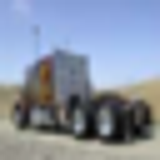

Image:2853 Gt:truck, 1st Pred:truck, 8.070, 2nd Pred:automobile, 3.339


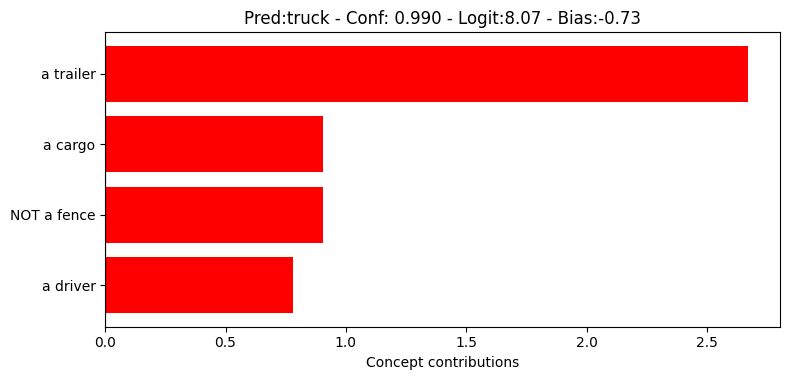

In [ ]:
from matplotlib import pyplot as plt
max_display = 4
random.seed = 42

val_pil_data = data_utils.get_data(f"{args.dataset}_val")

to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x = val_activations[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([160,160]))

        x = model.proj_layer(x)
        concept_act = (x-model.proj_mean)/model.proj_std
        outputs = model.final(concept_act)

        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))

        for k in range(1):
            contributions = (concept_act[0]*model.final.weight[top_classes[k], :]).cpu().numpy()
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])

            # Select top features by absolute contribution
            max_display = min(max_display, len(contributions))
            top_indices = np.argsort(np.abs(contributions))[-max_display:]#[::-1]
            top_values = contributions[top_indices]
            top_labels = [feature_names[i] for i in top_indices]

            # Plot
            colors = ['red' if val > 0 else 'blue' for val in top_values]
            y_pos = np.arange(len(top_values))

            plt.figure(figsize=(8, 0.6 * len(top_values) + 1.5))
            plt.barh(y_pos, top_values, color=colors)
            plt.yticks(y_pos, top_labels)
            plt.axvline(0, color='black', linewidth=0.8)
            plt.xlabel("Concept contributions")
            if title:
                plt.title(title)
            plt.tight_layout()
            plt.show()

